In [ ]:
# Download OLMO checkpoint and look at:
#
# Download the OLMO checkpoints of interest and figure out how to load weights
# for specific parts of the model.
#
# Look at weights:
# - Select early, mid, and late checkpoints
# - Download the checkpoints
# - Figure out how to view specific layers in the checkpoint
# - Verify we understand the OLMO architecture
#   - Check how many attention matrices there are
#   - Check how many ffn matricies there are
# - Plot
#   - embed/unembed weights
#   - q, k, v, o, ffn weights at first, middle, and last layer
# - Analyze the data
#   - What do we expect to see?
#   - early checkpoints normally distributed at all positions and matrix type
#   - middle and last checkpoint may have a diverged distribution at some positions
#     or matrix type? most likely embed or unembed
#
# Look at activations:
# - Set up an OLMO dataloader that can load data at the correct step offset
# - Look at OLMO activation distribution when inferenced on this batch of data
#
# Look at weight trajectories:
# - Both at the parameter and distribution level
# - Both across the full training run and just between checkpoints


In [12]:
# Look at weights

# We'll use the 'allenai/OLMo-7B-0424-hf' model since it has checkpoints available every
# 1000 steps. I think the model's warmed up for 2500 since t_warmup in the config is
# 10485760000 which = 2500 after dividing by 1024 (bs) and 4096 (context).
# Note: Warm-up affects LR, but not optimizer momentum or variance.

# We use the HF API to load checkpoints
from huggingface_hub import list_repo_refs
from transformers import AutoModelForCausalLM

MODEL = 'allenai/OLMo-7B-0424-hf'

out = list_repo_refs('allenai/OLMo-7B-0424-hf')
branches = [b.name for b in out.branches]

selected_steps = [500, 100_000, 300_000, 600_000]
checkpoint_branches = []

for step_choice in selected_steps:
    for ckpt in branches:
        if ckpt.startswith(f'step{step_choice}-tokens'):
            checkpoint_branches.append(ckpt)

b = checkpoint_branches[0]
print(b)

olmo = AutoModelForCausalLM.from_pretrained('allenai/OLMo-7B-0424-hf', revision=b)


step500-tokens2B


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


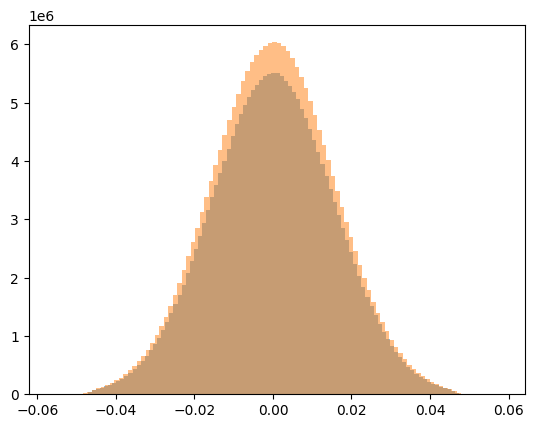

In [22]:
# Look at olmo model weights

from matplotlib import pyplot as plt

# olmo.model.embed_tokens (Embedding)
# olmo.model.layers[i].self_attn
#   - q_proj (Linear)
#   - k_proj (Linear)
#   - v_proj (Linear)
#   - o_proj (Linear)
# olmo.model.layers[i].mlp
#   - gate_proj (Linear)
#   - up_proj (Linear)
#   - down_proj (Linear)
# olmo.lm_head (Linear)

embed_weights = olmo.model.embed_tokens.weight
unembed_weights = olmo.lm_head.weight

# layers = [0, 16, 31]
layer = 0

q_proj = olmo.model.layers[layer].self_attn.q_proj.weight
k_proj = olmo.model.layers[layer].self_attn.k_proj.weight
v_proj = olmo.model.layers[layer].self_attn.v_proj.weight
o_proj = olmo.model.layers[layer].self_attn.o_proj.weight

gate_proj = olmo.model.layers[layer].mlp.gate_proj.weight
up_proj = olmo.model.layers[layer].mlp.up_proj.weight
down_proj = olmo.model.layers[layer].mlp.down_proj.weight

# Note: The weights are initialized via "mitchell" normalization:
#   attn_out_std = 1 / (math.sqrt(2 * self.config.d_model * (self.layer_id + 1)))
#   ff_out_std = 1 / (math.sqrt(2 * self.ff_out.in_features * (self.layer_id + 1)))
#   cutoff_factor = self.config.init_cutoff_factor or 3.0

# 
# _ = plt.hist(embed_weights.detach().numpy().flatten(), bins=100, alpha=.5, label='embed')
# _ = plt.hist(unembed_weights.detach().numpy().flatten(), bins=100, alpha=.5, label='unembed')
